### 讀檔案

In [1]:
import rarfile
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing

# Set to full path of unrar.exe if it is not in PATH
rarfile.UNRAR_TOOL = "unrar.exe"

# Set to '\\' to be more compatible with old rarfile
rarfile.PATH_SEP = '\\'

rar_path = os.getcwd() + "\\" + "sample_data.rar"
test_path = os.getcwd() + "\\" + "831測驗集.rar"


def un_rar(file_name):
    rar = rarfile.RarFile(file_name)
    rar.extractall()
    rar.close()

def OnlyNum(s,oth=''):      
    fomart = '.0123456789'  
    for c in s:   
        if not c in fomart:   
             s = s.replace(c,''); 
    s = float(s)                            # str2num
   # if s > 1.0:
   #     s = 1.0
    return s

# 訓練資料的名稱
train_rar = rarfile.RarFile(rar_path)
rar_namelist = train_rar.namelist()        # type list

# 測試資料的名稱
test_rar = rarfile.RarFile(test_path)
test_namelist = test_rar.namelist()

# 讀取初始資料
df_ex = pd.read_excel(str(rar_namelist[0]))
df_test = pd.read_excel(str(test_namelist[0]))

# 將第一列insert維dataframe的columns(因為讀取檔案將數值設定為cols)
ar_ex = df_ex.values            # dataframe轉array
ar_ex = np.insert(ar_ex, 0, values=df_ex.columns, axis=0)
df_ex = pd.DataFrame(ar_ex, columns=['col0', 'col1', 'col2', 'col3'])  # array轉dataframe


label_ex = df_ex.loc[df_ex.shape[0]-1, 'col0']             # 目標(第0行最後一列)
df_ex = df_ex.drop([df_ex.shape[0]-1])                     # dataframe去掉最後一列

print(df_ex.shape)
print(label_ex)
df_ex.head(3)

(7500, 4)
加工品質量測結果:0.306


,col0,col1,col2,col3
0,2.29658e-05,2.12655e-05,1.98152e-05,2.05591e-05
1,2.25512e-05,2.04522e-05,1.65414e-05,3.7598e-06
2,1.12122e-05,1.06301e-05,9.00514e-06,8.94675e-07


### 訓練資料(train_set)、驗證資料(validation_set)和標籤(Label)

In [2]:
def read_data(rar_namelist, tag=1, validation_percent=10):
    df_row_num = df_ex.shape[0]
    df_col_num = df_ex.shape[1]
    
    data_set = np.zeros(shape=(len(rar_namelist)-1, df_row_num*df_col_num))
 
    if tag == 0:
        label_df = pd.DataFrame(columns=['label'])
        
    for i in range(len(rar_namelist)-1):                  # 40
        df = pd.read_excel(str(rar_namelist[i]))
        ar = np.insert(df.values, 0, values=df.columns, axis=0)
        df = pd.DataFrame(ar, columns=['col0', 'col1', 'col2', 'col3'])  # array轉dataframe
        if tag == 0:
            label_df = label_df.append({'label': OnlyNum(df.loc[df.shape[0]-1, 'col0'])}, ignore_index=True)
            df = df.drop([df.shape[0]-1])
        
        data_set[i, 0:df_row_num] = df['col0']
        data_set[i, df_row_num:df_row_num*2] = df['col1']
        data_set[i, df_row_num*2:df_row_num*3] = df['col2']
        data_set[i, df_row_num*3:df_row_num*4] = df['col3']
        
    # 資料標準化(0~1)
    #min_max_scaler = preprocessing.MinMaxScaler()
    #data_set = min_max_scaler.fit_transform(data_set)
    
    if tag != 0:
        return data_set
    
    # 隨機將訓練資料分為訓練資料和驗證資料
    permutations = np.random.permutation(data_set.shape[0])   # 隨機排列
    data_set = data_set[permutations]
    train_label = label_df.values[permutations]

    validation_set = data_set[:validation_percent]            # 取後面10%
    validation_label = train_label[:validation_percent]

    train_set = data_set[validation_percent:]                 # 取前面90%
    train_label = train_label[validation_percent:]
        
    return train_set, train_label, validation_set, validation_label


train_set, train_label, validation_set, validation_label = read_data(rar_namelist, 0)
test_set = read_data(test_namelist)

print("train set shape：", train_set.shape)
print("train label shape：", train_label.shape)
print("validation set shape：", validation_set.shape)
print("validation label shape：", validation_label.shape)
print("test set shape：", test_set.shape)

train set shape： (30, 30000)
train label shape： (30, 1)
validation set shape： (10, 30000)
validation label shape： (10, 1)
test set shape： (10, 30000)


### NN model

In [3]:
import tensorflow as tf

# Parameters
learning_rate = 0.01
steps = 3000
display_step = 100

# Network Parameters
n_hidden_1 = 128   # 1st layer number of neurons
n_hidden_2 = 256   # 2nd layer number of neurons
num_input = 30000    
num_classes = 1    # output

# tf Graph input and outpur
X = tf.placeholder(tf.float32, [None, num_input])
Y = tf.placeholder(tf.float32, [None, 1])

C:\Users\Ncuee_lab418\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, num_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

In [5]:
# Create model
def neural_net(x):
    # 1st Hidden fully connected layer with 200 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    
    # 2nd Hidden fully connected layer with 300 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

In [6]:
# Construct model(預測)
logits = neural_net(X)    # 最後面沒經過activation function
tf_pred = logits
#tf_pred = tf.nn.relu(logits)

# Define loss(MSE) 
#tf_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=Y))
tf_loss = tf.reduce_mean(tf.reduce_sum(tf.square(Y - tf_pred)))       # Y丟標籤值

#Define optimizer(Adam)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
#optimizer = tf.train.AdagradOptimizer(learning_rate = learning_rate)
train_op = optimizer.minimize(tf_loss)

# Define accuracy
correct_diff = 1 - tf.abs((Y-tf_pred)/Y)                            # 計算向量內每一個的準確率
tf_acc = 100*tf.reduce_mean(tf.cast(correct_diff, tf.float32))      # 準確率取平均

### Train

In [7]:
from time import time
# 計算時間
startTime = time()

# 訓練過程資料
history = [(0, np.nan, 10)] # Initial Error Measures

# 儲存model
saver = tf.train.Saver()

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)         # Run the initializer

# 計算時間
startTime = time()

# 跑steps次(epoch=steps/display_step)
for step in range(1, steps+1):
    fd = {X:train_set, Y:train_label}
    sess.run(train_op, feed_dict=fd)

    # training loss
    if step % display_step == 0 or step==1:
        # Calculate loss and accuracy
        fd = {X:validation_set, Y:validation_label}
        val_loss, val_acc = sess.run([tf_loss, tf_acc], feed_dict=fd)     
        
        history.append((step, val_loss, val_acc))
        print("Step " + str(step) + ", training Loss= " + "{:.4f}".format(val_loss) +
                                    ", Training Accuracy= " + "{:f}".format(val_acc))

save_path = saver.save(sess, "tmp/model.ckpt")
print("Model saved in path: %s" % save_path)
sess.close

duration = time()-startTime
print("Train Finished takes:", duration)

Step 1, training Loss= 514877.6875, Training Accuracy= -45206.949219
Step 100, training Loss= 7.7665, Training Accuracy= -70.683441
Step 200, training Loss= 0.2075, Training Accuracy= 73.964577
Step 300, training Loss= 0.1826, Training Accuracy= 75.911781
Step 400, training Loss= 0.1658, Training Accuracy= 77.912727
Step 500, training Loss= 0.1584, Training Accuracy= 79.793434
Step 600, training Loss= 0.1582, Training Accuracy= 80.788269
Step 700, training Loss= 0.1619, Training Accuracy= 80.931892
Step 800, training Loss= 0.1675, Training Accuracy= 80.391426
Step 900, training Loss= 0.1730, Training Accuracy= 79.999802
Step 1000, training Loss= 0.1776, Training Accuracy= 79.789124
Step 1100, training Loss= 0.1809, Training Accuracy= 79.741272
Step 1200, training Loss= 0.1832, Training Accuracy= 79.798141
Step 1300, training Loss= 0.1846, Training Accuracy= 79.923759
Step 1400, training Loss= 0.1854, Training Accuracy= 80.094704
Step 1500, training Loss= 0.1857, Training Accuracy= 80.3

### 畫出loss誤差和accuracy準確率執行結果

C:\Users\Ncuee_lab418\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


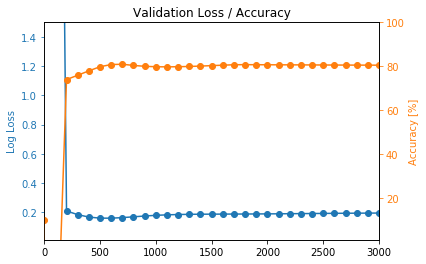

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

steps, loss, acc = zip(*history)

fig = plt.figure()
plt.title('Validation Loss / Accuracy')
ax_loss = fig.add_subplot(111)
ax_acc = ax_loss.twinx()
plt.xlabel('Training Steps')
plt.xlim(0, max(steps))

ax_loss.plot(steps, loss, '-o', color='C0')
ax_loss.set_ylabel('Log Loss', color='C0');
ax_loss.tick_params('y', colors='C0')
ax_loss.set_ylim(0.01, 1.5)

ax_acc.plot(steps, acc, '-o', color='C1')
ax_acc.set_ylabel('Accuracy [%]', color='C1');
ax_acc.tick_params('y', colors='C1')
ax_acc.set_ylim(1,100)

plt.show()

### 預測測試資料

In [9]:
saver = tf.train.Saver()
# 還原model並預測
with tf.Session() as sess:
    saver.restore(sess, "tmp/model.ckpt")
    print("Model restored.")
    test_preds = sess.run(tf_pred, feed_dict={X:test_set})
    print(test_preds)

INFO:tensorflow:Restoring parameters from tmp/model.ckpt
Model restored.
[[0.36559963]
 [0.62116146]
 [0.52091885]
 [0.60631466]
 [0.5720892 ]
 [0.5464392 ]
 [0.7319174 ]
 [0.67551327]
 [0.4772482 ]
 [0.50916195]]


In [10]:
# 輸出結果為.csv檔
df = pd.DataFrame(test_preds)
df[0].to_csv("submission.csv", index=False)